<a href="https://colab.research.google.com/github/matand380/ATDL_project_MonetStyleGenerator_2024/blob/main/ATDL_project_MonetStyleGenerator_2024-template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Deep Learning - Final Project**

## Team Information
- **Course:** Advenced topics in Deep Learning

- **Semester:** Fall 2024

- **Lectrurer:** Dr. Moshe Butman

- **Institution:** The College of Management Academic Studies

- **Team Members:** Eviatar Didon 313205387, Matan Drabkin 201416690, Tal Mekler 318811122, Lior Hasin 318231792, Daniel Margolin 314899436

## Project Overview

### Objective

- The objective of our project is to participate in a Kaggle competition focused on generating images in the style of the artist Oscar Claude Monet from real images. To achieve this goal, we plan to implement the CycleGAN architecture.

- The CycleGAN architecture consists of two generator networks and two discriminator networks, each dedicated to translating images between the two domains of interest. The generators aim to learn the mapping from one domain to the other (e.g., from real images to Monet-style images and vice versa), while the discriminators aim to distinguish between real and generated images in each domain.

- Key to the success of CycleGAN is the cycle-consistency loss, which enforces the consistency between the original image and the image translated back to the original domain. This loss helps ensure that the translated images preserve important content while being transformed into the desired style.

- By using the CycleGAN architecture, our goal is to build a model that can create Monet-style images from real ones effectively. Ultimately, we aim to win the Kaggle competition by showcasing the strengths of our model.


## Define imports


In [ ]:
import gdown
import os
import cv2
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import pytz

from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, BinaryCrossentropy

from contextlib import redirect_stdout


# <font color='burlywood'>Kaggle Dataset Downloading and Unzipping</font>



## Prerequisites
Ensure that the necessary packages (`kaggle`) are installed before running the code. Use the following command to install the `kaggle` package:


In [ ]:
!pip install --upgrade kaggle

### Uploading Kaggle API Key

Use the file picker to upload your Kaggle API key:


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


### Move API Key to the needed Directory

After uploading the API key, please ensure that Kaggle can use the API key for authentication.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### download and unzip the dataset

In [ ]:
!kaggle competitions download -c gan-getting-started
!unzip gan-getting-started.zip

gan-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gan-getting-started.zip
replace monet_jpg/000c1e3bff.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Define paths and DataFrames

In [ ]:
#Paths
monet_dir = '/content/monet_jpg'
photo_dir = '/content/photo_jpg'

#DataFrames
def create_dataframe_from_directory(directory):
    file_paths = [os.path.join(directory, file_name) for file_name in os.listdir(directory) if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))]
    df = pd.DataFrame(file_paths, columns=['file_path'])
    return df

# Create DataFrames
monet_df = create_dataframe_from_directory(monet_dir)
photo_df = create_dataframe_from_directory(photo_dir)

print("Monet DataFrame:")
print(monet_df.head())
print("\nPhoto DataFrame:")
print(photo_df.head())

Monet DataFrame:
                           file_path
0  /content/monet_jpg/066fe4cbaa.jpg
1  /content/monet_jpg/c6c88ce9c4.jpg
2  /content/monet_jpg/da72006ef5.jpg
3  /content/monet_jpg/3deea9f4a4.jpg
4  /content/monet_jpg/932d0dd808.jpg

Photo DataFrame:
                           file_path
0  /content/photo_jpg/33032dc5ad.jpg
1  /content/photo_jpg/a4a867e38f.jpg
2  /content/photo_jpg/67cb59fe1b.jpg
3  /content/photo_jpg/b128c9759f.jpg
4  /content/photo_jpg/22b5b48553.jpg


## Mount google drive in order to keep track of experiments



In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive')

drive_path = '/content/gdrive/My Drive/Colab Notebooks/CycleGAN_Monet_project'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# <font color='Coral'>Data Exploration<font>


### Let's plot examples of our images in the dataset

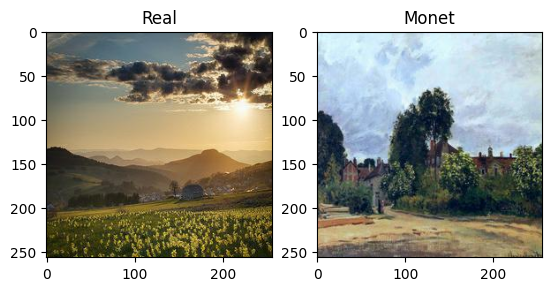

In [ ]:
# Read the images
photo_example = mpimg.imread('/content/photo_jpg/00068bc07f.jpg')
monet_example = mpimg.imread('/content/monet_jpg/a8fbbe3eb1.jpg')
# Plotting the images
plt.subplot(1,2,1)
plt.title('Real')
plt.imshow(photo_example)

plt.subplot(1,2,2)
plt.title('Monet')
plt.imshow(monet_example)

plt.show()


# <font color='Teal'>Preprocessing<font>


- Let's check the dimensions of the images

In [ ]:
def get_numpy_image_dimensions(image_array):

    if image_array.ndim == 3:  # Color image
        height, width, channels = image_array.shape
    elif image_array.ndim == 2:  # Grayscale image
        height, width = image_array.shape
        channels = 1
    else:
        raise ValueError("Unsupported image array shape")

    return (height, width, channels)


photo_example_dim = get_numpy_image_dimensions(photo_example)
monet_example_dim = get_numpy_image_dimensions(monet_example)

print(f"Photo image dimensions: {photo_example_dim}")
print(f"Monet image dimensions: {monet_example_dim}")


Photo image dimensions: (256, 256, 3)
Monet image dimensions: (256, 256, 3)


- Let's create ImageDataGenerators

In [ ]:
def create_image_data_generator(data_df, img_height, img_width, batch_size):
    datagen = ImageDataGenerator(
        rescale=1./127.5,
        preprocessing_function=lambda x: x - 1.0

        ############
        # consider add augmentations to the paintings (but seperate the generators)
        #############
    )

    generator = datagen.flow_from_dataframe(
        dataframe=data_df,
        x_col='file_path',
        y_col=None,
        target_size=(img_height, img_width),
        class_mode=None,  # No labels are needed
        batch_size=batch_size,
        shuffle=True
    )

    return generator


In [ ]:
img_height = 320
img_width = 320
batch_size = 1


# Create generators
monet_generator = create_image_data_generator(monet_df, img_height, img_width, batch_size)
photo_generator = create_image_data_generator(photo_df, img_height, img_width, batch_size)


Found 300 validated image filenames.
Found 7038 validated image filenames.


# <font color='Slate'>Build the CycleGAN architecture<font>


In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, BatchNormalization, Add
from tensorflow.keras.initializers import RandomNormal

def residual_block(x, filters):

    init = RandomNormal(stddev=0.02)
    y = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer=init)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer=init)(y)
    y = BatchNormalization()(y)
    # Add the input x back to the output
    y = Add()([y, x])
    return y

def build_generator(input_shape):
    inputs = Input(shape=input_shape)
    init = RandomNormal(stddev=0.02)

    # Start with a Conv layer
    x = Conv2D(64, kernel_size=5, strides=1, padding='same', kernel_initializer=init)(inputs) # kernel_size changed from 7 to 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Downsampling
    x = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual Blocks
    for _ in range(2):  # Using 2 for simplicity, adjust as needed
        x = residual_block(x, 128)

    # Upsampling
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer
    x = Conv2D(3, kernel_size=7, padding='same', kernel_initializer=init)(x)
    x = Activation('tanh')(x)  # Output scaled between -1 and 1

    model = Model(inputs, outputs=x, name="generator")
    return model


In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.initializers import RandomNormal

def build_discriminator(input_shape):
    init = RandomNormal(stddev=0.02)
    inputs = Input(shape=input_shape)

    # Convolutional layer 1
    x = Conv2D(64, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Convolutional layer 2
    x = Conv2D(128, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Convolutional layer 3
    x = Conv2D(256, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Flatten and Dense for classification
    x = Flatten()(x)
    x = Dense(1, kernel_initializer=init)(x)
    output = Activation('sigmoid')(x)

    model = Model(inputs, output, name="discriminator")
    return model

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.initializers import RandomNormal

def build_patchgan_discriminator(input_shape, start_filters=64):

    init = RandomNormal(stddev=0.02)
    inputs = Input(shape=input_shape)

    # Base number of filters
    filters = start_filters

    # Block 1: Convolution -> BatchNormalization -> ReLU
    x = Conv2D(filters, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Increment the number of filters with each block
    filters *= 2

    # Block 2
    x = Conv2D(filters, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    filters *= 2

    # Block 3
    x = Conv2D(filters, kernel_size=4, strides=2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer - No sigmoid activation is used at the end
    # The model will output a 2D map where each element corresponds to the patch of the input image
    x = Conv2D(1, kernel_size=4, strides=1, padding='same', kernel_initializer=init)(x)

    model = Model(inputs, x, name="patchgan_discriminator")
    return model

This CycleGAN class implementation provides the backbone for training a CycleGAN model capable of translating between two distinct domains: Monet paintings and photographs. The class is structured to encapsulate both the generators and discriminators for the two domains, ensuring a clean and organized approach to defining and training the model.

Key components of the class include:

- **Generators (`generator_photo` and `generator_monet`)**: These neural networks are tasked with generating images in one domain (e.g., Monet paintings) from images in the other domain (e.g., photographs), and vice versa.
  
- **Discriminators (`discriminator_photo` and `discriminator_monet`)**: These networks differentiate real images from generated ones within their respective domains, playing a critical role in the adversarial training process.

The `compile` method is overridden to accept optimizers for each generator and discriminator, allowing for flexibility in the choice of optimization algorithms and parameters.

The `train_step` method orchestrates the training process, implementing the forward pass, loss calculations, and backpropagation for both generators and discriminators. It leverages `tf.GradientTape` for automatic differentiation, enabling efficient calculation of gradients for all trainable parameters.

Loss functions calculated within `train_step` include:
- **Generator Loss**: Measures how well the generator tricks the discriminator into believing the generated images are real.
- **Discriminator Loss**: Evaluates the discriminator's ability to distinguish real images from fake ones.
- **Cycle Consistency Loss**: Ensures that an image translated from one domain to the other and back again remains as close as possible to the original image, preserving content.
- **Identity Loss**: Encourages the generator to act as an identity function when provided with an image already in the target domain.

Incorporation of Soft and Noisy Labels:
- This model incorporates the use of soft and noisy labels within the training process, a technique aimed at improving the robustness and stability of the training. Soft labels deviate from the binary hard labels traditionally used (0s for fake images and 1s for real images), by employing values that are close to but not exactly 0 or 1, adding a layer of uncertainty to the discriminator's task. Noisy labels introduce randomness into the labeling process, further complicating the discriminator's job by preventing it from relying on label certainty, which can lead to overfitting. These strategies collectively contribute to a more dynamic and challenging learning environment, promoting the development of more sophisticated and resilient models.

This CycleGAN class was built with the helpof Amy Jang's Monet [CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) on Kaggle.

In [ ]:
import tensorflow as tf

class CycleGAN(Model):
    def __init__(self, generator_photo, generator_monet, discriminator_photo, discriminator_monet):
        super(CycleGAN, self).__init__()
        self.generator_photo = generator_photo
        self.generator_monet = generator_monet
        self.discriminator_photo = discriminator_photo
        self.discriminator_monet = discriminator_monet

    def compile(self, gen_photo_optimizer, gen_monet_optimizer, disc_photo_optimizer, disc_monet_optimizer):
        super(CycleGAN, self).compile()
        self.gen_photo_optimizer = gen_photo_optimizer
        self.gen_monet_optimizer = gen_monet_optimizer
        self.disc_photo_optimizer = disc_photo_optimizer
        self.disc_monet_optimizer = disc_monet_optimizer

    def train_step(self, data):
        real_photo, real_monet = data

        # Soft label boundaries
        soft_label_min, soft_label_max = 0.7, 1.2
        soft_label_fake_min, soft_label_fake_max = 0.0, 0.3

        with tf.GradientTape(persistent=True) as tape:
            # Monet to photo and back to Monet (cycle)
            fake_monet = self.generator_monet(real_photo, training=True)
            cycled_photo = self.generator_photo(fake_monet, training=True)

            # Photo to Monet and back to Photo (cycle)
            fake_photo = self.generator_photo(real_monet, training=True)
            cycled_monet = self.generator_monet(fake_photo, training=True)

            # Identity mapping
            same_photo = self.generator_photo(real_photo, training=True)
            same_monet = self.generator_monet(real_monet, training=True)

            # Discriminator predictions
            disc_real_photo = self.discriminator_photo(real_photo, training=True)
            disc_real_monet = self.discriminator_monet(real_monet, training=True)
            disc_fake_photo = self.discriminator_photo(fake_photo, training=True)
            disc_fake_monet = self.discriminator_monet(fake_monet, training=True)

            # Generate soft labels with some noise
            real_labels = tf.random.uniform(shape=tf.shape(disc_real_photo), minval=soft_label_min, maxval=soft_label_max)
            fake_labels = tf.random.uniform(shape=tf.shape(disc_fake_photo), minval=soft_label_fake_min, maxval=soft_label_fake_max)


            # Calculate losses with soft and noisy labels
            gen_photo_loss = generator_loss(disc_fake_photo, real_labels)
            gen_monet_loss = generator_loss(disc_fake_monet, real_labels)
            total_cycle_loss = calc_cycle_loss(real_photo, cycled_photo) + calc_cycle_loss(real_monet, cycled_monet)

            total_gen_photo_loss = gen_photo_loss + total_cycle_loss + identity_loss(real_photo, same_photo)
            total_gen_monet_loss = gen_monet_loss + total_cycle_loss + identity_loss(real_monet, same_monet)

            disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
            disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)


        return {
            "monet_gen_loss": total_gen_monet_loss,
            "photo_gen_loss": total_gen_photo_loss,
            "monet_disc_loss": disc_monet_loss,
            "photo_disc_loss": disc_photo_loss
        }

# Creating the needed instances and Compile the CycleGAN Model

In [ ]:
# Create generator models
generator_monet_to_photo = build_generator(input_shape=(320, 320, 3))
# print(generator_monet_to_photo.summary())  # uncomment if you need

generator_photo_to_monet = build_generator(input_shape=(320, 320, 3))
# print(generator_photo_to_monet.summary())  # uncomment if you need

# Create discriminator models
discriminator_photo = build_discriminator(input_shape=(320, 320, 3))
# print(discriminator_photo.summary())  # uncomment if you need

discriminator_monet = build_discriminator(input_shape=(320, 320, 3))
# print(discriminator_monet.summary())  # uncomment if you need

# Create PatchGAN discriminator model
patchgan_discriminator_photo = build_patchgan_discriminator(input_shape=(320, 320, 3))
# print(patchgan_discriminator_photo.summary())  # uncomment if you need

patchgan_discriminator_monet = build_patchgan_discriminator(input_shape=(320, 320, 3))
# print(patchgan_discriminator_monet.summary())  # uncomment if you need



# Create CycleGAN model
cycleGAN = CycleGAN(generator_photo=generator_monet_to_photo, generator_monet=generator_photo_to_monet,
                    discriminator_photo=discriminator_photo, discriminator_monet=patchgan_discriminator_monet)

# Create optimizer instances
from tensorflow.keras.optimizers import legacy

gen_optimizer = legacy.Adam(2e-4, 0.5)
disc_optimizer = legacy.Adam(2e-4, 0.5)

# Compile the CycleGAN model
cycleGAN.compile(gen_photo_optimizer=gen_optimizer, gen_monet_optimizer=gen_optimizer,
                 disc_photo_optimizer=disc_optimizer, disc_monet_optimizer=disc_optimizer)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


# Define loss functions

In [ ]:

from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
import tensorflow as tf

from tensorflow.keras.losses import BinaryCrossentropy

def discriminator_loss(real, generated, real_labels, fake_labels):
    loss_fn = BinaryCrossentropy(from_logits=True)
    real_loss = loss_fn(real_labels, real)
    generated_loss = loss_fn(fake_labels, generated)
    total_disc_loss = (real_loss + generated_loss) * 0.5
    return total_disc_loss


def generator_loss(generated, labels):
    return MeanSquaredError()(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA=10):
    cycled_loss = MeanAbsoluteError()(real_image, cycled_image)
    return LAMBDA * cycled_loss

def identity_loss(real_image, same_image, LAMBDA=0.5):
    id_loss = MeanAbsoluteError()(real_image, same_image)
    return LAMBDA * id_loss


# Train the cycleGAN model

In [ ]:
def generate_combined_batches(photo_generator, monet_generator):
    while True:
        photo_batch = next(photo_generator)
        monet_batch = next(monet_generator)
        yield (photo_batch, monet_batch)  # Yielding a tuple of (photo, monet)

In [ ]:
combined_generator = generate_combined_batches(photo_generator, monet_generator)

In [ ]:

# Set the timezone to Jerusalem
jerusalem_tz = pytz.timezone('Asia/Jerusalem')
# Generate a date-based identifier
date_id = datetime.now(jerusalem_tz).strftime('%Y-%m-%d_%H-%M-%S')

# Define the main directory path for this training session
training_session_dir = f'/content/gdrive/MyDrive/Colab Notebooks/CycleGAN_Monet_project/training_session_{date_id}'

os.makedirs(training_session_dir, exist_ok=True)

# Redirect model summaries to files within this directory
model_names = ['generator_photo', 'generator_monet', 'discriminator_photo', 'discriminator_monet']
for model_name in model_names:
    model = getattr(cycleGAN, model_name)
    summary_path = os.path.join(training_session_dir, f'{model_name}_summary.txt')
    with open(summary_path, 'w') as f:
        with redirect_stdout(f):
            model.summary()

csv_log_path = os.path.join(training_session_dir, 'training_log.csv')

# Initialize the CSVLogger with the path
csv_logger = tf.keras.callbacks.CSVLogger(csv_log_path, append=True)

steps_per_epoch = min(len(photo_generator), len(monet_generator))

history = cycleGAN.fit(
    combined_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,  # Adjust the number of epochs as needed
    callbacks=[csv_logger]
)

In [ ]:
import matplotlib.pyplot as plt

# Plotting the generator and discriminator losses
plt.figure(figsize=(10, 5))

plt.plot(history.history['monet_gen_loss'], label='Monet Generator Loss')
plt.plot(history.history['photo_gen_loss'], label='Photo Generator Loss')
plt.plot(history.history['monet_disc_loss'], label='Monet Discriminator Loss')
plt.plot(history.history['photo_disc_loss'], label='Photo Discriminator Loss')

plt.title('Training Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:

# Generate a date-based identifier
date_id = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Define a main directory for the experiment
experiment_dir = f'/content/gdrive/MyDrive/Colab Notebooks/CycleGAN_Monet_project/models/exp_{date_id}'

# Define save paths within this main experiment directory
monet_to_photo_gen_save_path = f'{experiment_dir}/monet_to_photo_gen'
photo_to_monet_gen_save_path = f'{experiment_dir}/photo_to_monet_gen'
monet_disc_save_path = f'{experiment_dir}/monet_disc'
photo_disc_save_path = f'{experiment_dir}/photo_disc'


os.makedirs(experiment_dir, exist_ok=True)

# Save the models individually in the designated subdirectories of the experiment directory
cycleGAN.generator_photo.save(monet_to_photo_gen_save_path, save_format='tf')
cycleGAN.generator_monet.save(photo_to_monet_gen_save_path, save_format='tf')
cycleGAN.discriminator_monet.save(monet_disc_save_path, save_format='tf')
cycleGAN.discriminator_photo.save(photo_disc_save_path, save_format='tf')


# Evaluation and Visualization of the results

generate some photos

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to load and preprocess images
def load_and_preprocess_images(directory, image_size=(320, 320), num_images=None):
    images = []
    # List all image paths
    image_paths = [os.path.join(directory, file_name) for file_name in os.listdir(directory) if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))]
    # Optionally, limit the number of images to load
    if num_images is not None:
        image_paths = image_paths[:num_images]
    # Load and preprocess each image
    for image_path in image_paths:
        image = load_img(image_path, target_size=image_size)
        image = img_to_array(image)
        image = (image - 127.5) / 127.5  # Normalize the image to [-1, 1]
        images.append(image)
    # Convert the list of images to a NumPy array
    images_array = np.array(images)
    return images_array

# Function to generate Monet paintings from test photos
def generate_monet_paintings(generator, test_photos, num_imgs_to_generate=5):
    generated_images = []
    for i in range(num_imgs_to_generate):
        photo = np.expand_dims(test_photos[i], axis=0)  # Expand dims to include batch size
        monet_style_image = generator.predict(photo)
        generated_images.append(monet_style_image[0])  # Remove batch dimension
    return generated_images

test_photo_dir = '/content/photo_jpg'
test_photos = load_and_preprocess_images(test_photo_dir, image_size=(320, 320), num_images=5)

# Generate Monet-style paintings
generated_monet_paintings = generate_monet_paintings(cycleGAN.generator_monet, test_photos, num_imgs_to_generate=5)


1/1 [==============================] - 0s 22ms/step


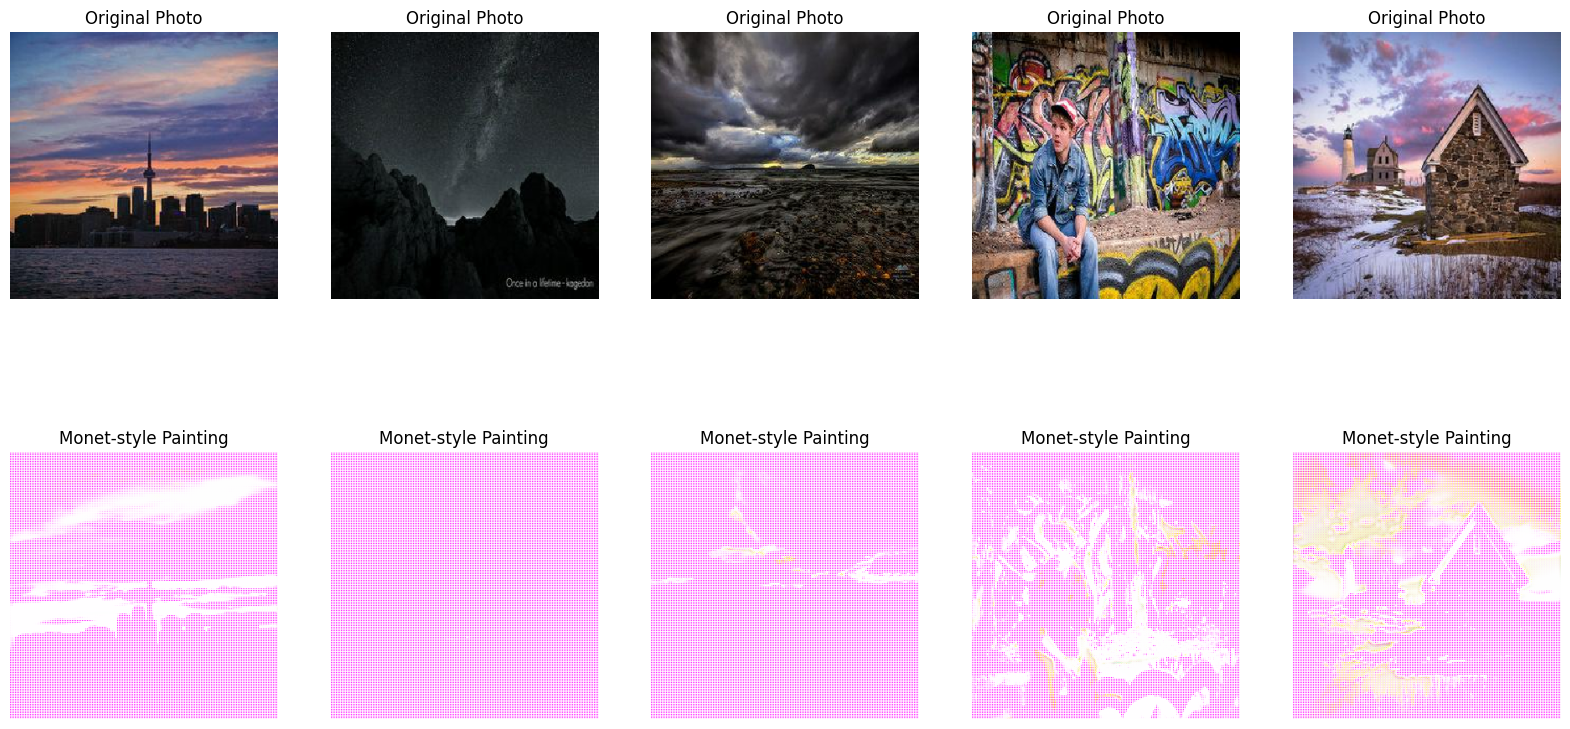

In [ ]:
import matplotlib.pyplot as plt

def visualize_generated_images(original_photos, generated_images):
    plt.figure(figsize=(20, 10))
    for i in range(len(generated_images)):
        # Display original image
        ax = plt.subplot(2, len(generated_images), i + 1)
        plt.imshow(original_photos[i] * 0.5 + 0.5)  # Rescale the image pixel values to [0, 1]
        plt.title("Original Photo")
        plt.axis("off")

        # Display generated image
        ax = plt.subplot(2, len(generated_images), i + 1 + len(generated_images))
        plt.imshow(generated_images[i] * 0.5 + 0.5)  # Rescale the image pixel values to [0, 1]
        plt.title("Monet-style Painting")
        plt.axis("off")

    plt.show()

visualize_generated_images(test_photos, generated_monet_paintings)


In [ ]:
print(f"Original test photo dimensions: {test_photos[0].shape}")
print(f"Generated painting dimensions: {generated_monet_paintings[0].shape}")

Original test photo dimensions: (320, 320, 3)
Generated painting dimensions: (320, 320, 3)


In [ ]:
# implement imresize function to resize from (320, 320, 3) to (256, 256, 3)

# Submission file creation

In [ ]:
import PIL
! mkdir ../images

In [ ]:
# loop over the monet generated images and save them to dir

In [ ]:
import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# needs to fit to google colab